In [1]:

## train의 test값을 저장 한다. 
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
        
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs

def plotGraph(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)

        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
       
        return [EpochsT[:,:,:], EpochsN[:,:,:]]


def main():
    #root = 'D:\\VR300Data\\0129\\Eunjin\\Training\\mat\\Training.mat'
    root =  'D:\\VR300_20\\S08\\Training\\mat\\Training.mat'
    T_all= np.zeros((210,7,180))
    N_all= np.zeros((210,7,180))

    [T_all[:,:,:],N_all[:,:,:]]=plotGraph(root)
    mat_file = io.loadmat(root)
    
    target_data = T_all
    non_target_data = N_all

    print(target_data.shape)
    print(non_target_data.shape)
#-----------------------------------------
    output_file = "./resampled_data_test.npz"
    np.savez(output_file, np.array(target_data,dtype=float), np.array(non_target_data,dtype=float))
#-------------------------------------

    
if __name__ == "__main__":
    main()

(210, 7, 180)
(210, 7, 180)


In [21]:
# DataProcessing and model generation process
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import hdf5storage
import numpy as np
from scipy.signal import butter, lfilter
import os,glob
from scipy import signal
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

def Re_referencing(eegData, channelNum, sampleNum):
        after_car = np.zeros((channelNum,sampleNum))
        for i in np.arange(channelNum):
            after_car[i,:] = eegData[i,:] - np.mean(eegData,axis=0)
        return after_car

def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y
def Make_Average_Component(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
    NumT_Aver = NumT-componentNum
    NumN_Aver = NumN-componentNum
    
    EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
    EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
    for i in range(NumT_Aver):
        EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
    for j in range(NumN_Aver):
        EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
    return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]


def Epoching(eegData, stims, samplingFreq, channelNum, epochSampleNum, offset, baseline):
        Time_after = np.add(stims,offset).astype(int)
        Time_base = np.add(stims,baseline).astype(int)
        Num = stims.shape[1]
        Epochs = np.zeros((Num, channelNum, epochSampleNum))
        for j in range(Num):
            Epochs[j, :, :] = eegData[:,Time_after[0][j]:Time_after[0][j] + epochSampleNum]
            
        return [Epochs,Num]


def resampling(Epochs, EpochNum, resampleRate, channelNum):
        resampled_epoch = np.zeros((EpochNum, channelNum, resampleRate))
        for i in range(EpochNum):
            for j in range(channelNum):
                resampled_epoch[i,j,:] = signal.resample(Epochs[i,j,:], resampleRate)
        return resampled_epoch


    

def Epoching_d(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]

def Convert_to_featureVector(EpochsT, NumT, EpochsN, NumN, featureNum):
        FeaturesT = np.zeros((NumT, featureNum))
        for i in range(NumT):
            FeaturesT[i,:] = np.reshape(EpochsT[i,:,:],(1,featureNum))
        FeaturesN = np.zeros((NumN, featureNum))
        for j in range(NumN):
            FeaturesN[j,:] = np.reshape(EpochsN[j,:,:],(1,featureNum))
        return [FeaturesT,FeaturesN]


def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
    
def Standardization(Epochs):
        for i in range(Epochs.shape[1]):
            Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
            Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
        return Epochs
    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs
def Make_Average_Component_d(EpochsT, NumT, EpochsN, NumN, channelNum, epochSampleNum, componentNum):
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        NumT_Aver = NumT-componentNum
        NumN_Aver = NumN-componentNum
    
        EpochsT_Aver = np.zeros((NumT_Aver, channelNum, epochSampleNum))
        EpochsN_Aver = np.zeros((NumN_Aver, channelNum, epochSampleNum))
        for i in range(NumT_Aver):
            EpochsT_Aver[i, :, :] = np.mean(EpochsT[i:i+componentNum, :, :], axis=0)
        for j in range(NumN_Aver):
            EpochsN_Aver[j, :, :] = np.mean(EpochsN[j:j+componentNum, :, :], axis=0)
        
        return [EpochsT_Aver, NumT_Aver, EpochsN_Aver, NumN_Aver]

def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_d(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_d(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        #Convert to feature vector
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)

        return [EpochsT[:,:,:], EpochsN[:,:,:]]    
def plotGraph_b(filename):
        channelNum = 7
        epochSampleNum = 512
        epochNum = 150
        resampleRate = 300
        target = np.zeros((epochNum,1,resampleRate))
        nontarget = np.zeros((epochNum,1,resampleRate))


        mat = hdf5storage.loadmat(filename)
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq'][0,0]
        stimsN = mat['stimsN']
        stimsT = mat['stimsT']
        sampleNum = eegData.shape[1]
        channelIndex = [18, 30, 12, 11, 19, 10, 15]
            
            # vr300 7 channel
            # [P4, Fz, Pz, P3, PO8, PO7, Oz]
            # [19, 31, 13, 12, 20, 11, 16]
            
        eegData = eegData[channelIndex]
            
            ## Preprocessing process
        eegData = Re_referencing(eegData, channelNum, eegData.shape[1])
            
            #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, 4)
        
#             #Epoching
        epochSampleNum = int(np.floor(1 * samplingFreq))
        offset = int(np.floor(0 * samplingFreq))
        baseline = int(np.floor(1 * samplingFreq))
        [EpochsT, NumT] = Epoching(eegData, stimsT, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching(eegData, stimsN, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        NumN = NumT
        EpochsN = Balancing_DataSet(EpochsN, NumN)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN)
        EpochsT_Aver = resampling(EpochsT, NumT, resampleRate, channelNum) 
        EpochsN_Aver = resampling(EpochsN, NumN, resampleRate, channelNum)

        
        return [EpochsT_Aver, EpochsN_Aver]
def main():
    hz=180   
    
    
 #--------------------------------------------------------------    
    root = 'D:\\VR300_20\\S'
    T_all_V= np.zeros((17*210,7,hz))
    N_all_V= np.zeros((17*210,7,hz))
    count = 0
        
    for i in np.arange(1,20):
        if(i==7 or i==13 or i==16): continue
        if(i<10):
            count = count + 1
            root_VR = root + '0' + str(i)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        else:
            count = count + 1
            root_VR = root + str(i)+'/Training/mat/'
            current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
            root_VR = current_list[0]
        [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
#-------------------------------------------------------

    filename = ''
    channelNum = 7 # (n_components)
    epochSampleNum = 300
    epochNum = 150
    epochNum_N = 150
    subject_num = []
    root = 'D:\\P300_biosemi_55\\S'
    T_all = np.zeros((epochNum*49,channelNum,hz))
    N_all = np.zeros((epochNum_N*49,channelNum,hz))
    count =0
    
    co = np.zeros((49,7))
    
    for l in np.arange(1,56):
        if(l==25 or l==44 or l==53 or l==6 or l==38 or l==52): 
            continue
        if(l<10):
            count = count + 1
            filename = root + '0' + str(l)
        else:
            count = count +1
            filename = root + str(l)
        T_all_b= np.zeros((epochNum,7,epochSampleNum))
        N_all_b= np.zeros((epochNum_N,7,epochSampleNum))
        
        [T_all_b[:,:,:],N_all_b[:,:,:]]=plotGraph_b(filename)
        
        Target_All=np.mean(T_all_V,axis=0)
        target_data_b = np.mean(T_all_b, axis=0)
        
        mat = np.zeros((2, hz))
        for j in np.arange(0,7):
            mat[0] = Target_All[j,:]
            coef = np.zeros(75)
            for b in np.arange(0,75):
                mat[1] = target_data_b[j,0*hz+1*b:1*hz+1*(b)]
                corrcoef = np.corrcoef(mat)
                coef[b] = corrcoef[0,1]
            index = np.argmax(np.abs(coef))
            co[count-1,j] = coef[index]
            #print('index:')
            #print(index)
            
        #biosemi 맞춰주기
            start = 0*hz+1*index
            finish = 1*hz+1*(index)
        
            T_all_b[:,j,0:hz] = T_all_b[:,j,start:finish]
            N_all_b[:,j,0:hz] = N_all_b[:,j,start:finish]
            T_all_mean = np.mean(T_all_b, axis=0)
            if coef[index] < 0:
                T_all_b[:,j,0:hz] = T_all_b[:,j,0:hz]*(-1)
                T_all_mean = np.mean(T_all_b, axis=0)
                #print('inverse')
            
        #높이 맞추기
            #print(max(mat[0]))
            #print(max(T_all_mean[j,:]))
            rate=max(mat[0])/max(T_all_mean[j,:])
            T_all_b[:,j,0:hz] = T_all_b[:,j,0:hz]*rate
            N_all_b[:,j,0:hz] = N_all_b[:,j,0:hz]*rate
        

        [T_all[epochNum*(count-1):epochNum*count,:,:],N_all[epochNum_N*(count-1):epochNum_N*count,:,:]] = [T_all_b[:,:,0:hz],N_all_b[:,:,0:hz]]
        print("subject {0} is preprocessed".format(str(l)))
    

    
    tdata = np.concatenate((T_all[:,:,:],T_all_V[:,:,:]),axis=0)
    ntdata = np.concatenate((N_all[:,:,:],N_all_V[:,:,:]),axis =0)
     
#-----------------------------------------
    output_file = "./resampled_data_Bio_correlation_1.npz"
    np.savez(output_file, np.array(tdata,dtype=float), np.array(ntdata,dtype=float))
#-------------------------------------

    
if __name__ == "__main__":
    main()

subject 1 is preprocessed
subject 2 is preprocessed
subject 3 is preprocessed
subject 4 is preprocessed
subject 5 is preprocessed
subject 7 is preprocessed
subject 8 is preprocessed
subject 9 is preprocessed
subject 10 is preprocessed
subject 11 is preprocessed
subject 12 is preprocessed
subject 13 is preprocessed
subject 14 is preprocessed
subject 15 is preprocessed
subject 16 is preprocessed
subject 17 is preprocessed
subject 18 is preprocessed
subject 19 is preprocessed
subject 20 is preprocessed
subject 21 is preprocessed
subject 22 is preprocessed
subject 23 is preprocessed
subject 24 is preprocessed
subject 26 is preprocessed
subject 27 is preprocessed
subject 28 is preprocessed
subject 29 is preprocessed
subject 30 is preprocessed
subject 31 is preprocessed
subject 32 is preprocessed
subject 33 is preprocessed
subject 34 is preprocessed
subject 35 is preprocessed
subject 36 is preprocessed
subject 37 is preprocessed
subject 39 is preprocessed
subject 40 is preprocessed
subject 4

In [22]:
import numpy as np

filename = "./resampled_data_Bio_correlation_1.npz"
npzfile = np.load(filename)
print(npzfile.files)

target_data = npzfile['arr_0']
non_target_data = npzfile['arr_1']

print("Target data shape: ", target_data.shape)
print("Non-target data shape: ", non_target_data.shape)
'''
file2 = "./resampled_data_test.npz"
npzfile2 = np.load(file2)
print(npzfile2.files)

test_data = npzfile2['arr_0']
non_test_data = npzfile2['arr_1']

print("Target data shape: ", test_data.shape)
print("Non-target data shape: ", non_test_data.shape)
'''

['arr_0', 'arr_1']
Target data shape:  (10920, 7, 180)
Non-target data shape:  (10920, 7, 180)


'\nfile2 = "./resampled_data_test.npz"\nnpzfile2 = np.load(file2)\nprint(npzfile2.files)\n\ntest_data = npzfile2[\'arr_0\']\nnon_test_data = npzfile2[\'arr_1\']\n\nprint("Target data shape: ", test_data.shape)\nprint("Non-target data shape: ", non_test_data.shape)\n'

In [23]:
from sklearn.model_selection import train_test_split
'''
X_train = np.concatenate([target_data, non_target_data])
y_train = np.concatenate([np.ones(target_data.shape[0]), np.zeros(non_target_data.shape[0])])
X_test = np.concatenate([test_data, non_test_data])
y_test = np.concatenate([np.ones(test_data.shape[0]), np.zeros(non_test_data.shape[0])])
'''

X = np.concatenate([target_data, non_target_data])
y = np.concatenate([np.ones(target_data.shape[0]), np.zeros(non_target_data.shape[0])])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print(y_train)
print("\nX_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(y_test)

X_train shape:  (16380, 7, 180)
Y_train shape:  (16380,)
[1. 0. 0. ... 0. 0. 0.]

X_test shape:  (5460, 7, 180)
y_test shape:  (5460,)
[1. 0. 1. ... 0. 1. 1.]


In [24]:
import warnings
import torch
import random
warnings.filterwarnings("ignore")

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(777)

In [25]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool  # N x 3 x 180 -> N x 3 x 45
        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x

In [26]:
from EEGDataset import EEGDataset
from torch.utils.data import DataLoader
import torch

batch_size = 4

train_loader = DataLoader(
                EEGDataset(X_train, y_train), 
                batch_size=batch_size, 
                shuffle=True)

test_loader = DataLoader(
                EEGDataset(X_test, y_test),
                batch_size=batch_size,
                shuffle=False)

In [27]:
import torch
import torch.nn as nn
from torch import optim

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr) # Adam optimizer -->내려가는 방법 생각해보기 == lr learning mate 적절하게 하면 좋다. adam 은 0.001 줄여보면서 
epochs = 20

In [28]:
from sklearn.metrics import accuracy_score

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

num_batches = len(train_loader)
for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    for i, data in enumerate(train_loader):
        """ 
        이번 학습에 사용될 데이터를 Batch 단위로 불러옵니다.
        우리는 이전에 batch_size를 4로 설정했으므로, 4개의 데이터가 불러와집니다.
        """

        data, label = data['data'].float().to(DEVICE), data['labels'].float().to(DEVICE)
        """
        optimizer.zero_grad(): 함수를 사용하여 기존에 남아있던 gradient를 모두 제거해줍니다.
        이는 이전 데이터가 새로 학습될 데이터에 영향을 끼치는 것을 막아줍니다.
        
        output = model(data): CNN 모델에 학습 데이터를 넣고 결과를 만들어냅니다.
        
        loss = criterion(output, label): 모델이 만들어낸 결과와, 실제 정답간의 차이를 이용해서 오차 값을 만들어 냅니다.
        추후에 이 값을 이용하여 모델이 학습을 하게 됩니다.
        
        loss.backward(): 위에서 만들어낸 오차 값을 각 노드에게 전파하여 각 노드가 업데이트 해야 할 오차가 얼마인지 찾아냅니다.
        
        optimizer.stop(): 각 노드별로 받은 오차를 가지고 optimizer의 방법 (여기서는 Adam)을 기반으로 weight를 업데이트 합니다.
        """
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # Visualization을 위해 loss값과 accuracy를 저장합니다.
        train_loss += loss.item()
        train_acc += accuracy_score(np.argmax(label.cpu().detach().numpy(), axis=1), np.argmax(output.cpu().detach().numpy(), axis=1))
        
        """
        10번의 batch마다 test를 진행합니다.
        모델을 test할 때는 weight를 업데이트 시키면 안되기 때문에 torch.no_grad()를 이용합니다.
        freconnected --> deep learning transfer learning 
        """
        if (i + 1) % 1000 == 0:
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                for j, test_data in enumerate(test_loader):
                    test_data, test_label = test_data['data'].float().to(DEVICE), test_data['labels'].float().to(DEVICE)
                    test_output = model(test_data)
                    loss = criterion(test_output, test_label)
                    
                    test_loss += loss.item()
                    test_acc += accuracy_score(np.argmax(test_label.cpu().detach().numpy(), axis=1), np.argmax(test_output.cpu().detach().numpy(), axis=1))
            
            print('epoch: {}/{} | step: {}/{} | train_loss: {:.4f} | test_loss: {:.4f} | acc: {:.4f}'.format(
                epoch + 1, epochs, i + 1, num_batches, train_loss / 1000, test_loss / len(test_loader), test_acc / len(test_loader)
            ))
            
            train_loss_list.append(train_loss / 1000)
            train_acc_list.append(train_acc / 1000)
            test_loss_list.append(test_loss / len(test_loader))
            test_acc_list.append(test_acc / len(test_loader))
            train_loss = 0
            train_acc = 0

epoch: 1/20 | step: 1000/4095 | train_loss: 0.7405 | test_loss: 0.7299 | acc: 0.5018
epoch: 1/20 | step: 2000/4095 | train_loss: 0.7310 | test_loss: 0.7242 | acc: 0.5079
epoch: 1/20 | step: 3000/4095 | train_loss: 0.7263 | test_loss: 0.7197 | acc: 0.5143
epoch: 1/20 | step: 4000/4095 | train_loss: 0.7126 | test_loss: 0.7166 | acc: 0.5176
epoch: 2/20 | step: 1000/4095 | train_loss: 0.7197 | test_loss: 0.7128 | acc: 0.5198
epoch: 2/20 | step: 2000/4095 | train_loss: 0.7112 | test_loss: 0.7101 | acc: 0.5227
epoch: 2/20 | step: 3000/4095 | train_loss: 0.7115 | test_loss: 0.7076 | acc: 0.5233
epoch: 2/20 | step: 4000/4095 | train_loss: 0.7099 | test_loss: 0.7056 | acc: 0.5258
epoch: 3/20 | step: 1000/4095 | train_loss: 0.7070 | test_loss: 0.7031 | acc: 0.5260
epoch: 3/20 | step: 2000/4095 | train_loss: 0.7087 | test_loss: 0.7013 | acc: 0.5260
epoch: 3/20 | step: 3000/4095 | train_loss: 0.6968 | test_loss: 0.6995 | acc: 0.5277
epoch: 3/20 | step: 4000/4095 | train_loss: 0.6981 | test_loss: 0

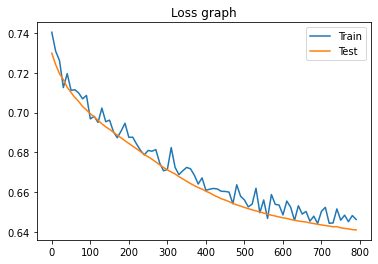

In [31]:
import matplotlib.pyplot as plt

x_tick = np.arange(0, len(train_loss_list) * 10, 10)
plt.title('Loss graph')
plt.plot(x_tick, train_loss_list, label='Train')
plt.plot(x_tick, test_loss_list, label='Test')
plt.legend()

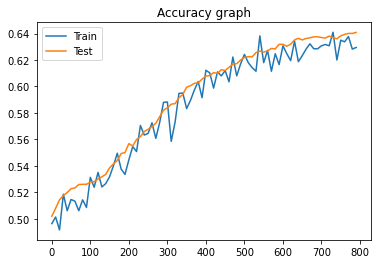

In [32]:
x_tick = np.arange(0, len(train_acc_list) * 10, 10)
plt.title('Accuracy graph')
plt.plot(x_tick, train_acc_list, label='Train')
plt.plot(x_tick, test_acc_list, label='Test')
plt.legend()

In [33]:
model_save='D:/P300_biosemi_55/Model/Bio/ZERO_Bio.pt'
model_save_weights='D:/P300_biosemi_55/Model/Bio/Weight/ZERO_Weight_Bio.pt'

torch.save(model, model_save)
torch.save(model.state_dict(), model_save_weights)
model.eval()

CNN(
  (bn1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Conv1d(7, 3, kernel_size=(3,), stride=(1,), padding=(True,))
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=135, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)

In [18]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model

Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
        
def main():

        root_path = "D:\\VR300Data\\0129\\Minchul\\"

        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 0.6* samplingFreq))
            offset = int(np.floor(0.2 * samplingFreq))
            baseline = int(np.floor(0.8 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                
            b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/15)

if __name__ == "__main__":
    main()

tensor([[0.5925, 0.4075],
        [0.4051, 0.5949],
        [0.3591, 0.6409],
        [0.5059, 0.4941],
        [0.4667, 0.5333],
        [0.3704, 0.6296],
        [0.5423, 0.4577]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(3, device='cuda:0')
tensor([[0.5080, 0.4920],
        [0.2031, 0.7969],
        [0.3799, 0.6201],
        [0.6674, 0.3326],
        [0.5923, 0.4077],
        [0.5994, 0.4006],
        [0.5291, 0.4709]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(2, device='cuda:0')
tensor([[0.1934, 0.8066],
        [0.6920, 0.3080],
        [0.2949, 0.7051],
        [0.7339, 0.2661],
        [0.4470, 0.5530],
        [0.6362, 0.3638],
        [0.3706, 0.6294]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
tensor([[0.4809, 0.5191],
        [0.3014, 0.6986],
        [0.3313, 0.6687],
        [0.2296, 0.7704],
        [0.6078, 0.3922],
        [0.6432, 0.3568],
        [0.6589, 0.341

In [19]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

    
def main():

        root_path = "D:\\VR300Data\\0129\\Minchul\\"
        root_VR =  'D:\\VR300_20\\S08\\Training\\mat\\Training.mat'
        T_all_V= np.zeros((210,7,180))
        N_all_V= np.zeros((210,7,180))
        [T_all_V[:,:,:],N_all_V[:,:,:]]=plotGraph_v(root_VR)
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 1* samplingFreq))
            offset = int(np.floor(0 * samplingFreq))
            baseline = int(np.floor(1 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
            
#*********************************************************
            hz=180
            
            target_data = Epochs_Aver[int(ans)-1,:,:]
            mat = np.zeros((2, hz))

            for j in np.arange(0,7):
                mat[0] = Target_All[j,:]
                coef = np.zeros(70)
                q=0
                for b in np.arange(0,70):
                    mat[1] = target_data[j,0*hz+1*b:1*hz+1*(b)]
                    corrcoef = np.corrcoef(mat)
                    coef[q] = corrcoef[0,1]
                    q=q+1
                index = np.argmax(np.abs(coef))
            #실시간 맞춰주기
                start = 0*hz+1*index
                finish = 1*hz+1*(index)
#*********************************************************   
            '''
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output)
            loss.backward()
            optimizer.step()
            '''
            
            b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/15)

if __name__ == "__main__":
    main()

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
tensor([[0.4631, 0.5369],
        [0.7717, 0.2283],
        [0.5033, 0.4967],
        [0.8008, 0.1992],
        [0.2117, 0.7883],
        [0.6751, 0.3249],
        [0.6831, 0.3169]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(5, device='cuda:0')
tensor([[0.3921, 0.6079],
        [0.1988, 0.8012],
        [0.5575, 0.4425],
        [0.4478, 0.5522],
        [0.7003, 0.2997],
        [0.6867, 0.3133],
        [0.8003, 0.1997]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(2, device='cuda:0')
tensor([[0.3364, 0.6636],
        [0.7506, 0.2494],
        [0.4190, 0.5810],
        [0.5560, 0.4440],
        [0.6684, 0.3316],
        [0.5455, 0.4545],
        [0.7722, 0.2278]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
tensor([[0.4902, 0.5098],
        [0.5622, 0.4378],
        [0.1160, 0.8840],
        [0.2248, 0.7752],
        [0.7620, 0.2380],
       

In [20]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from EEGDataset import EEGDataset
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN().to(DEVICE)
criterion = nn.BCELoss()
lr = 1e-5# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45
        )
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
     
def main():
        root_path = "D:\\VR300Data\\0129\\Minchul\\"
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 0.6* samplingFreq))
            offset = int(np.floor(0.2 * samplingFreq))
            baseline = int(np.floor(0.8 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
#######여기 라벨을 붙여주는곳
            target_data = np.zeros((1, 7, 180))
            non_target_data = np.zeros((6, 7, 180))
            B=0
            for i in np.arange(0,7):
                if i==int(ans)-1:
                    target_data=Epochs_Aver[i,:,:].reshape(1,7,180)
                else:
                    non_target_data[B,:,:]=Epochs_Aver[i,:,:].reshape(1,7,180)
                    B=B+1
            X_train = np.concatenate([target_data, non_target_data])
            y_train = np.concatenate([np.ones(target_data.shape[0]), np.zeros(non_target_data.shape[0])])
###############################        
            train_loader = DataLoader(
                EEGDataset(X_train, y_train), 
                batch_size=4, 
                shuffle=True)
    
            for i, data in enumerate(train_loader):
                data, label = data['data'].float().to(DEVICE), data['labels'].float().to(DEVICE)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()
            model_save='D:/P300_biosemi_55/Model/CorrX/BackP.pt'
            torch.save(model, model_save)
            model.eval()
                
            Classifier_path_B = 'D:\\P300_biosemi_55\\Model\\CorrX\\'
            classifier_list_B = sorted(glob.glob(Classifier_path_B + '*.pt'), key=os.path.getmtime, reverse=True)
            model_B = torch.load(classifier_list_B[0])
            b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
            test_output=model_B(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/15)

if __name__ == "__main__":
    main()

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
tensor([[0.5925, 0.4075],
        [0.4051, 0.5949],
        [0.3591, 0.6409],
        [0.5059, 0.4941],
        [0.4667, 0.5333],
        [0.3704, 0.6296],
        [0.5423, 0.4577]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(3, device='cuda:0')
tensor([[0.5707, 0.4293],
        [0.0443, 0.9557],
        [0.2346, 0.7654],
        [0.8194, 0.1806],
        [0.7251, 0.2749],
        [0.6464, 0.3536],
        [0.5252, 0.4748]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(2, device='cuda:0')
tensor([[0.0545, 0.9455],
        [0.7637, 0.2363],
        [0.1479, 0.8521],
        [0.8681, 0.1319],
        [0.4006, 0.5994],
        [0.7333, 0.2667],
        [0.2141, 0.7859]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
tensor([[0.4610, 0.5390],
        [0.1553, 0.8447],
        [0.2183, 0.7817],
        [0.0810, 0.9190],
        [0.6445, 0.3555],
       

In [15]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from EEGDataset import EEGDataset

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

    
def main():

        root_path = "D:\\VR300Data\\0129\\Minchul\\"
        root_VR =  'D:\\VR300_20\\S08\\Training\\mat\\Training.mat'
        T_all_V= np.zeros((210,7,180))
        N_all_V= np.zeros((210,7,180))
        [T_all_V[:,:,:],N_all_V[:,:,:]]=plotGraph_v(root_VR)
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum_B = int(np.floor( 0.6* samplingFreq))
            offset_B = int(np.floor(0.2 * samplingFreq))
            baseline_B = int(np.floor(0.8 * samplingFreq))
            
            #Epoching
            epochSampleNum = int(np.floor( 1* samplingFreq))
            offset = int(np.floor(0 * samplingFreq))
            baseline = int(np.floor(1 * samplingFreq))
                        
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            Epochs_Aver_B = np.zeros((buttonNum, channelNum, epochSampleNum_B))
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                Epochs_Aver_B[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum_B, offset_B, baseline_B)
#######여기 라벨을 붙여주는곳
            target_data = np.zeros((1, 7, 180))
            non_target_data = np.zeros((6, 7, 180))
            B=0
            for i in np.arange(0,7):
                if i==int(ans)-1:
                    target_data=Epochs_Aver_B[i,:,:].reshape(1,7,180)
                else:
                    non_target_data[B,:,:]=Epochs_Aver_B[i,:,:].reshape(1,7,180)
                    B=B+1
            X_train = np.concatenate([target_data, non_target_data])
            y_train = np.concatenate([np.ones(target_data.shape[0]), np.zeros(non_target_data.shape[0])])
###############################        
            train_loader = DataLoader(
                EEGDataset(X_train, y_train), 
                batch_size=4, 
                shuffle=True)
    
            for i, data in enumerate(train_loader):
                data, label = data['data'].float().to(DEVICE), data['labels'].float().to(DEVICE)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()
            model_save='D:/P300_biosemi_55/Model/CorrX/BackP.pt'
            torch.save(model, model_save)
            model.eval()
                
            Classifier_path_B = 'D:\\P300_biosemi_55\\Model\\CorrX\\'
            classifier_list_B = sorted(glob.glob(Classifier_path_B + '*.pt'), key=os.path.getmtime, reverse=True)
            model_B = torch.load(classifier_list_B[0])
            
#*********************************************************
            hz=180
            
            target_data = Epochs_Aver[int(ans)-1,:,:]
            mat = np.zeros((2, hz))

            for j in np.arange(0,7):
                mat[0] = Target_All[j,:]
                coef = np.zeros(70)
                q=0
                for b in np.arange(0,70):
                    mat[1] = target_data[j,0*hz+1*b:1*hz+1*(b)]
                    corrcoef = np.corrcoef(mat)
                    coef[q] = corrcoef[0,1]
                    q=q+1
                index = np.argmax(np.abs(coef))
            #실시간 맞춰주기
                start = 0*hz+1*index
                finish = 1*hz+1*(index)
#*********************************************************   
            b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
            test_output=model_B(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/15)

if __name__ == "__main__":
    main()

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
tensor([[0.4631, 0.5369],
        [0.7717, 0.2283],
        [0.5033, 0.4967],
        [0.8008, 0.1992],
        [0.2117, 0.7883],
        [0.6751, 0.3249],
        [0.6831, 0.3169]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(5, device='cuda:0')
tensor([[0.2417, 0.7583],
        [0.0403, 0.9597],
        [0.6188, 0.3812],
        [0.3729, 0.6271],
        [0.8504, 0.1496],
        [0.8265, 0.1735],
        [0.9504, 0.0496]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(2, device='cuda:0')
tensor([[0.1675, 0.8325],
        [0.8793, 0.1207],
        [0.3389, 0.6611],
        [0.5476, 0.4524],
        [0.7309, 0.2691],
        [0.5872, 0.4128],
        [0.9079, 0.0921]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
tensor([[0.4812, 0.5188],
        [0.6098, 0.3902],
        [0.0138, 0.9862],
        [0.0608, 0.9392],
        [0.8856, 0.1144],
       

In [16]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from EEGDataset import EEGDataset

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

    
def main():

        root_path = "D:\\VR300Data\\0129\\Minchul\\"
        root_VR =  'D:\\VR300_20\\S08\\Training\\mat\\Training.mat'
        T_all_V= np.zeros((210,7,180))
        N_all_V= np.zeros((210,7,180))
        [T_all_V[:,:,:],N_all_V[:,:,:]]=plotGraph_v(root_VR)
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)
            
            #Epoching
            epochSampleNum = int(np.floor( 1* samplingFreq))
            offset = int(np.floor(0 * samplingFreq))
            baseline = int(np.floor(1 * samplingFreq))
                        
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                
            #******************************************
            hz=180
            
            target_data = Epochs_Aver[int(ans)-1,:,:]
            mat = np.zeros((2, hz))

            for j in np.arange(0,7):
                mat[0] = Target_All[j,:]
                coef = np.zeros(70)
                q=0
                for b in np.arange(0,70):
                    mat[1] = target_data[j,0*hz+1*b:1*hz+1*(b)]
                    corrcoef = np.corrcoef(mat)
                    coef[q] = corrcoef[0,1]
                    q=q+1
                index = np.argmax(np.abs(coef))
            #실시간 맞춰주기
                start = 0*hz+1*index
                finish = 1*hz+1*(index)
#********************************************************* 
                
#######여기 라벨을 붙여주는곳
            target_data = np.zeros((1, 7, 180))
            non_target_data = np.zeros((6, 7, 180))
            B=0
            for i in np.arange(0,7):
                if i==int(ans)-1:
                    target_data=Epochs_Aver[i,:,start:finish].reshape(1,7,180)
                else:
                    non_target_data[B,:,:]=Epochs_Aver[i,:,start:finish].reshape(1,7,180)
                    B=B+1
            X_train = np.concatenate([target_data, non_target_data])
            y_train = np.concatenate([np.ones(target_data.shape[0]), np.zeros(non_target_data.shape[0])])
###############################        
            train_loader = DataLoader(
                EEGDataset(X_train, y_train), 
                batch_size=4, 
                shuffle=True)
    
            for i, data in enumerate(train_loader):
                data, label = data['data'].float().to(DEVICE), data['labels'].float().to(DEVICE)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, label)
                loss.backward()
                optimizer.step()
            model_save='D:/P300_biosemi_55/Model/CorrX/BackP.pt'
            torch.save(model, model_save)
            model.eval()
                
            Classifier_path_B = 'D:\\P300_biosemi_55\\Model\\CorrX\\'
            classifier_list_B = sorted(glob.glob(Classifier_path_B + '*.pt'), key=os.path.getmtime, reverse=True)
            model_B = torch.load(classifier_list_B[0])
            

            b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
            test_output=model_B(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/15)

if __name__ == "__main__":
    main()

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
tensor([[0.4631, 0.5369],
        [0.7717, 0.2283],
        [0.5033, 0.4967],
        [0.8008, 0.1992],
        [0.2117, 0.7883],
        [0.6751, 0.3249],
        [0.6831, 0.3169]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(5, device='cuda:0')
tensor([[0.2444, 0.7556],
        [0.0416, 0.9584],
        [0.6179, 0.3821],
        [0.3750, 0.6250],
        [0.8472, 0.1528],
        [0.8243, 0.1757],
        [0.9492, 0.0508]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(2, device='cuda:0')
tensor([[0.1689, 0.8311],
        [0.8759, 0.1241],
        [0.3418, 0.6582],
        [0.5490, 0.4510],
        [0.7311, 0.2689],
        [0.5870, 0.4130],
        [0.9056, 0.0944]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
tensor([[0.4831, 0.5169],
        [0.6082, 0.3918],
        [0.0144, 0.9856],
        [0.0621, 0.9379],
        [0.8826, 0.1174],
       

ans_label [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0]
1 score: 0.5641025641025641
ans_label [0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0]
2 score: 0.4
ans_label [0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0]
3 score: 0.3684210526315789
ans_label [1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
4 score: 0.43333333333333335
ans_label [0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0]
5 score: 0.4666666666666667
ans_label [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0]
6 score: 0.7
ans_label [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
8 score: 1.0
ans_label [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0]
9 score: 0.5666666666666667
ans_label [1

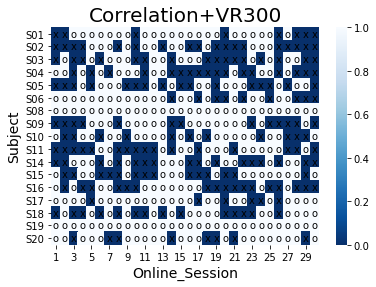

In [20]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from pandas import DataFrame  # 데이터프레임 클래스

import seaborn as sns

Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

resampleRate = 100    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs       
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
        #Epochs = baseline_correction(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def main():
    sum=0
    Total_Score=0.0
    total_label =[]
    for k in np.arange(1,21):
        if(k==7 or k==12 or k==13):
            continue
        root="D:\\VR300_20\\S"
        if(k<10):
            filename = root + '0' + str(k)
        else:
            filename = root + str(k)
        #root_path = "D:\\VR300_20\\S03\\"

        mat_path = filename + '\\Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        ans_label= []
        wrong_ans = []
        
        target_val = nontarget_val = 0
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor(0.6 * samplingFreq))
            offset = int(np.floor(0.2 * samplingFreq))
            baseline = int(np.floor(0.8 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))
            
            featureNum = channelNum*resampleRate
            
            for i in range(buttonNum):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
            #answer=model(Epochs_final)
            
            #print(Epochs_Aver.shape)
            b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            #print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                #ans_label.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                if(len(ans_label)>29):
                    continue
                ans_label.append(1)
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                if(len(ans_label)>29):
                    continue
                ans_label.append(0)
            #print('order: ', ans, 'predict: ', predict)
        
        print('ans_label', ans_label)
        total_label.append(ans_label)
        print(k,'score:', score/(len(wrong_ans)+score))
        
        if (k==1 or k==6 or k==8  or k==9 or k==10 or k==11 or k==15 or k==17 or k==19 or k==20):
            sum=sum+ score/(len(wrong_ans)+score)
    print(sum/10)
    print(total_label)
    df = pd.DataFrame(total_label,
                   index=['S01','S02','S03','S04','S05','S06','S08','S09','S10','S11','S14','S15','S16','S17','S18','S19','S20'],
                   columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
    print(df)
# heatmap by plt.pcolor()

    for i in range(df.shape[1]):
        for j in range(df.shape[0]):
            if round(df.iloc[j,i],2) == 1:
                plt.text(i+0.5,j+0.5,'o',ha='center',va='center')
            else:
                plt.text(i+0.5,j+0.5,'x',ha='center',va='center')

    sns.heatmap(df, cmap='Blues_r')
    plt.title('Correlation+VR300', fontsize=20)
    plt.xlabel('Online_Session', fontsize=14)
    plt.ylabel('Subject', fontsize=14)
    plt.show()



if __name__ == "__main__":
    main()